# DreamComp Reconstruction Weights

## Intro
* **Date**: 12/3/2020
* **What**: This is a one-layer, one-competition (KH) network with reconstruction weights.  Reconstruction weights are weights used during the reconstruction step, which should mathematically speaking increase the synapse weights corresponding to higher recon weights.
* **Why**: If neurons tend to have higher weights on one particular synapse, then that synapse is "more important," in the sense that it's largely responsible for the output of the neuron.  Then I believe that the neuron will naturally find prototypes in the other synapses that correlate with the more important synapses.  So in my case, the neurons will find things that are strongly correlated to the number "5," which should hopefully boost classification accuracy.  I already saw a non-trivial increase in network accuracy when I fed the classification vector into the neurons with the input vector, so if I make the classification vector component "more important" perhaps we'll see an even higher increase in classification accuracy.
* **Hopes**: Simple.  I hope that boosting recon weights for the classification vector increases the layer's prediction accuracy.
* **Limitations**: I can't think of any specific limitation right now, aside from the fact that everything breaks and fails an incredibly huge portion of the time.  I'm not even slightly bitter.  (I'm actually not bitter, I just like being dramatic).

## Technicals

Here's the weight update formula:

$$
\Delta w_i = v_i - \frac{1}{\zeta_i}\left<\vec{w}, \vec{v}\right> w_i
$$

The $\zeta_i$ terms are the reconstruction weights.  If they're higher, the network is forced to compensate more, which makes the $w_i$ with large $\zeta_i$ proportionally larger than the other weights, making those synapses more important (At least, in theory).

## Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from time import sleep, time

(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x, test_x = train_x / 255.0, test_x / 255.0

L = 28 * 28

flat_x = train_x.reshape(-1, L)
flat_test = test_x.reshape(-1, L)

In [2]:
def draw_weights(w, Kx, Ky, fig):
    tapestry = np.zeros((28 * Kx, 28 * Ky))
    
    w_i = 0
    for x in range(Kx):
        for y in range(Ky):
            tapestry[x * 28: (x + 1) * 28, y * 28: (y + 1) * 28] = w[w_i].reshape(28, 28)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Reds", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

In [3]:
"""
Kx: Num columns of neurons
Ky: Num rows of neurons
flat_x: Training data
train_y: Training classifications
Nep: Number of epochs
T_s: Number of inputs on which to train
B: Batch size
R: Reconstruction weight for classifications
xi: Learning constant
fig: Current plt figure
draw: Boolean indicating whether weights should be drawn at each epoch.

Returns: Synapse weight matrix w
"""
def dream_comp_recon_weights(Kx, Ky, flat_x, train_y, Nep, T_s, B, R, xi, fig, draw):
    N = Kx * Ky
    
    L = flat_x.shape[1]
    num_classes = np.max(train_y) + 1
    
    w = np.random.uniform(0, 1, (N, L + num_classes))
    
    num_inputs = train_y.shape[0]
    
    clsfn_vec = np.zeros((num_inputs, num_classes))
    clsfn_vec[np.arange(num_inputs), train_y] = 1
    
    full_input = np.concatenate((flat_x, clsfn_vec), axis=1)
    
    recon_vec = np.ones(L + num_classes)
    recon_vec[-num_classes:] = R
    
    for ep in range(Nep):
        inputs = full_input[np.random.permutation(num_inputs)]
        
        for i in tqdm(range(T_s // B)):
            v = inputs[i * B: (i + 1) * B]
            
            w_v = w @ v.T
            wins = np.argmax(w_v, axis=0)
            
            win_mask = np.zeros((N, B))
            win_mask[wins, np.arange(B)] = 1
            win_mask /= np.maximum(1, np.sum(win_mask, axis=1)).reshape(-1, 1)
            
            v_update = win_mask @ v
            w_v_update = np.sum(w_v * win_mask, axis=1).reshape(-1, 1)
            
            w += (v_update - (w_v_update * (w / recon_vec))) * xi
            
        if draw:
            draw_weights(w[:, :-num_classes], Kx, Ky, fig)
        
    return w

In [4]:
"""
Kx: Num columns of neurons
Ky: Num rows of neurons
flat_x: Training data
train_y: Training classifications
Nep: Number of epochs
T_s: Number of inputs on which to train
B: Batch size
R: Reconstruction weight for classifications
xi: Learning constant for the input weights.  
c_xi: Learning constant for the classification synapse weights
fig: Current plt figure
draw: Boolean indicating whether weights should be drawn at each epoch.

Returns: Synapse weight matrix w
"""
def dream_comp_recon_weights_custom_xi(Kx, Ky, flat_x, train_y, Nep, T_s, B, R, xi, c_xi, fig, draw):
    N = Kx * Ky
    
    L = flat_x.shape[1]
    num_classes = np.max(train_y) + 1
    
    w = np.random.uniform(0, 1, (N, L + num_classes))
    
    num_inputs = train_y.shape[0]
    
    clsfn_vec = np.zeros((num_inputs, num_classes))
    clsfn_vec[np.arange(num_inputs), train_y] = 1
    
    full_input = np.concatenate((flat_x, clsfn_vec), axis=1)
    
    recon_vec = np.ones(L + num_classes)
    recon_vec[-num_classes:] = R
    
    big_xi = np.full(L + num_classes, xi)
    big_xi[-num_classes:] = c_xi
    
    for ep in range(Nep):
        inputs = full_input[np.random.permutation(num_inputs)]
        
        for i in tqdm(range(T_s // B)):
            v = inputs[i * B: (i + 1) * B]
            
            w_v = w @ v.T
            wins = np.argmax(w_v, axis=0)
            
            win_mask = np.zeros((N, B))
            win_mask[wins, np.arange(B)] = 1
            win_mask /= np.maximum(1, np.sum(win_mask, axis=1)).reshape(-1, 1)
            
            v_update = win_mask @ v
            w_v_update = np.sum(w_v * win_mask, axis=1).reshape(-1, 1)
            
            w += (v_update - (w_v_update * (w / recon_vec))) * big_xi
            
        if draw:
            draw_weights(w[:, :-num_classes], Kx, Ky, fig)
        
    return w

In [5]:
def recon_classification(w, flat_test, test_y):
    num_classes = np.max(test_y) + 1
    classes = np.argmax(w[:, -num_classes:], axis=1)
    
    print("Classes: ", classes)
    
    a_w = w[:, :-num_classes]
    
    num_inputs = flat_test.shape[0]
    
    preds = classes[np.argmax(a_w @ flat_test.T, axis=0)]
    
    correct = np.zeros(num_inputs)
    correct[preds == test_y] = 1
    
    accuracy = np.sum(correct) / num_inputs
    
    print("Accuracy: ", str(100 * accuracy) + '%')
    
    return accuracy

In [6]:
def plot_class_weights(w, num_classes, x, y):
    fig = plt.figure(figsize=(x, y))
    
    w_cls = w[:, -num_classes:]
    
    for (i, cls_weights) in enumerate(w_cls[: x * y]):
        plt.subplot(y, x, i + 1)
        plt.bar(np.arange(num_classes), cls_weights)
        
    plt.show()

<IPython.core.display.Javascript object>


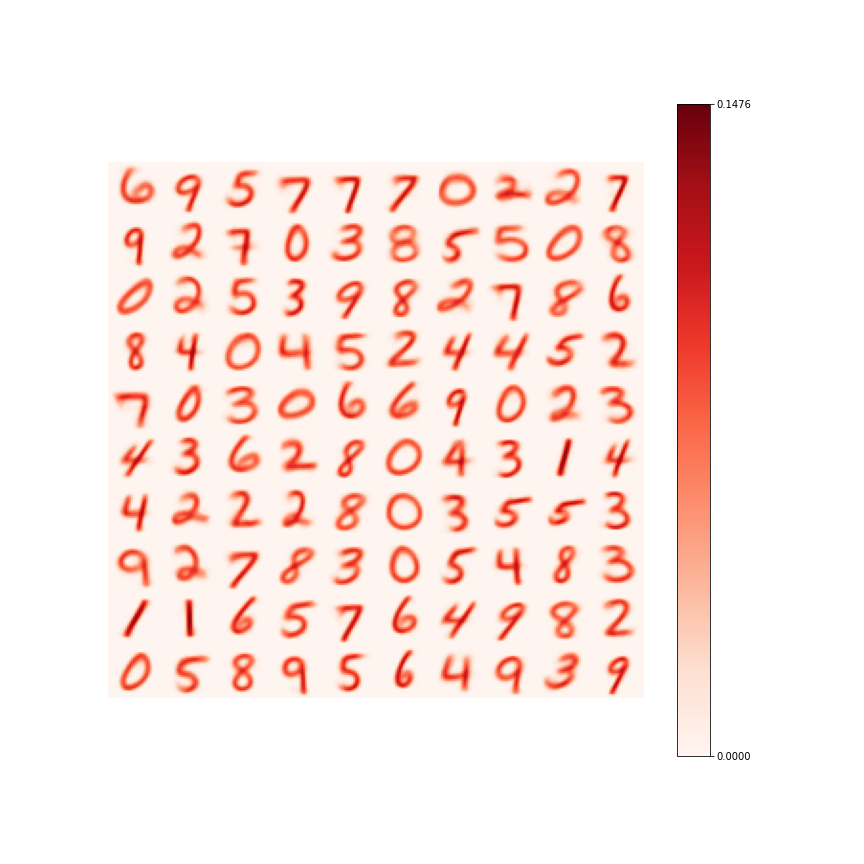

100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 802.14it/s]


<IPython.core.display.Javascript object>


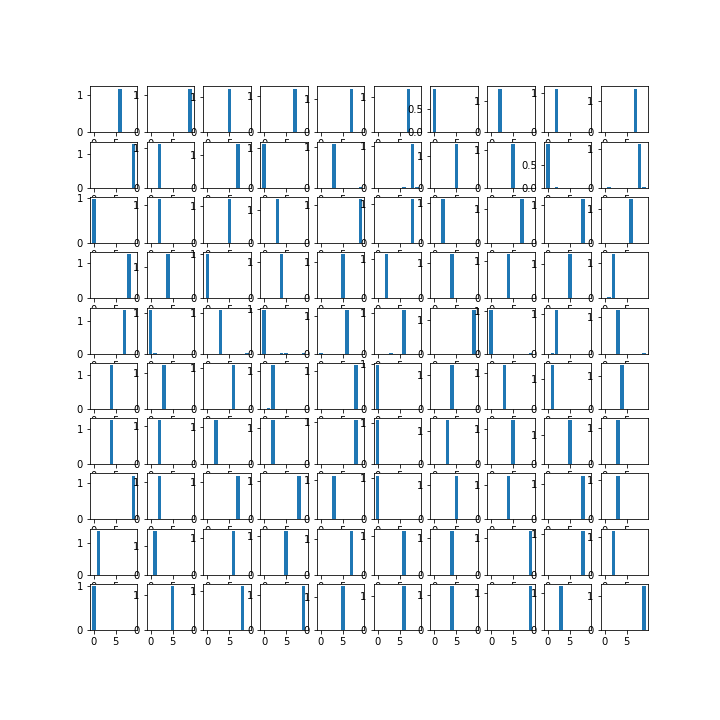

Classes:  [6 9 5 7 7 7 0 2 2 7 9 2 7 0 3 8 5 5 0 8 0 2 5 3 9 8 2 7 8 6 8 4 0 4 5 2 4
 4 5 2 7 0 3 0 6 6 9 0 2 3 4 3 6 2 8 0 4 3 1 4 4 2 2 2 8 0 3 5 5 3 9 2 7 8
 3 0 5 4 8 3 1 1 6 5 7 6 4 9 8 2 0 5 8 9 5 6 4 9 3 9]
Accuracy:  92.83%


In [96]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Kx = 10
Ky = 10
Nep = 15
T_s = 60000
B = 100
R = 10
xi = 0.003

w = dream_comp_recon_weights(Kx, Ky, flat_x, train_y, Nep, T_s, B, R, xi, fig, True)
plot_class_weights(w, 10, Kx, Ky)
acc = recon_classification(w, flat_test, test_y)

# Analysis Dialog  

HOLY SHIT!!! HOOOLLLLYYY SHIIIIIIIITTTTTT!

I just got (mostly) 100 autonomous neurons to get 92.83% accuracy!!! That's like 3% better than without any labeled input, and 11% better than Diehl!  Fuck yeah!! Who fucking cares about my no cussing rule now, bitch!!  Before I do any better analysis, I simply must try 400 neurons.

<IPython.core.display.Javascript object>


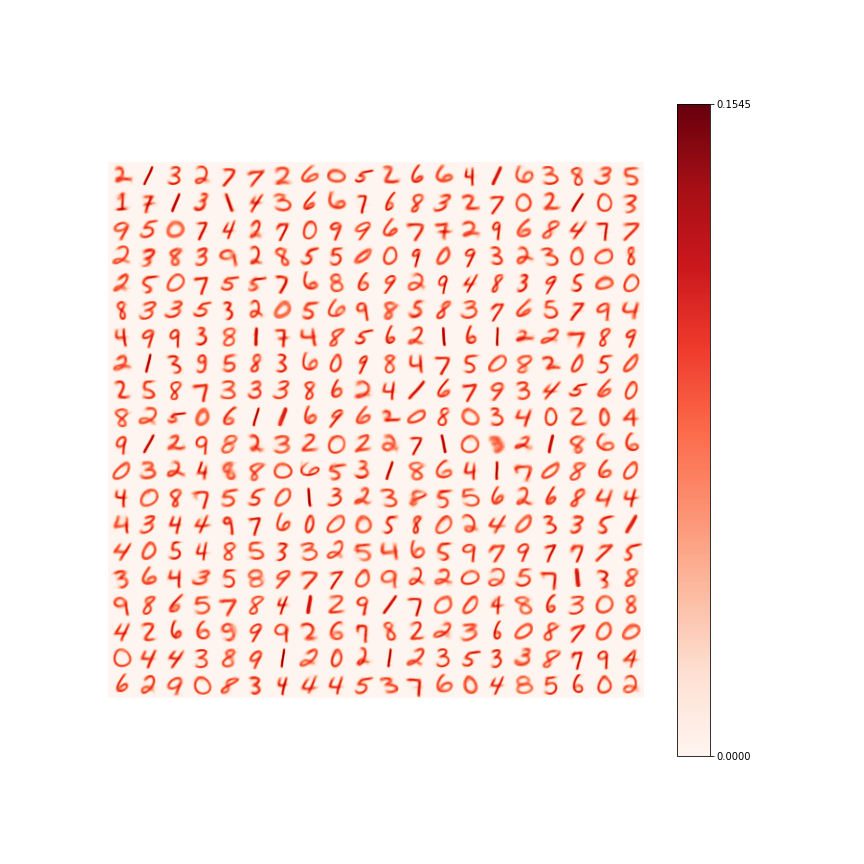

100%|██████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 122.05it/s]


Classes:  [2 1 3 2 7 7 2 6 0 5 2 6 6 4 1 6 3 8 3 5 1 7 1 3 1 4 3 6 6 7 6 8 3 2 7 0 2
 1 0 3 9 5 0 7 4 2 7 0 9 9 6 7 7 2 9 6 8 4 7 7 2 3 8 3 9 2 8 5 5 0 0 9 0 9
 3 2 3 0 0 8 2 5 0 7 5 5 7 6 8 6 9 2 9 4 8 3 9 5 0 0 8 3 3 5 3 2 0 5 6 9 8
 5 8 3 7 6 5 7 9 4 4 9 9 3 8 1 7 4 8 5 6 2 1 6 1 2 2 7 8 9 2 1 3 9 5 8 3 6
 0 9 8 4 7 5 0 8 2 0 5 0 2 5 8 7 3 3 3 8 6 2 4 1 6 7 9 3 4 5 6 0 8 2 5 0 6
 1 1 6 9 6 2 0 8 0 3 4 0 2 0 4 9 1 2 9 8 2 3 2 0 2 2 7 1 0 3 2 1 8 6 6 0 3
 2 4 8 8 0 6 5 3 1 8 6 4 1 7 0 8 6 0 4 0 8 7 5 5 0 1 3 2 3 8 5 5 6 2 6 8 4
 4 4 3 4 4 9 7 6 0 0 0 5 8 0 2 4 0 3 3 5 1 4 0 5 4 8 5 3 3 2 5 4 6 5 9 7 9
 7 7 7 5 3 6 4 3 5 8 9 7 7 0 9 2 2 0 2 5 7 1 3 8 9 8 6 5 7 8 4 1 2 9 1 7 0
 0 4 8 6 3 0 8 4 2 6 6 9 9 9 2 6 7 8 2 2 3 6 0 8 7 0 0 0 4 4 3 8 9 1 2 0 2
 1 2 3 5 3 3 8 7 9 4 6 2 9 0 8 3 4 4 4 5 3 7 6 0 4 8 5 6 0 2]
Accuracy:  95.00999999999999%


<IPython.core.display.Javascript object>


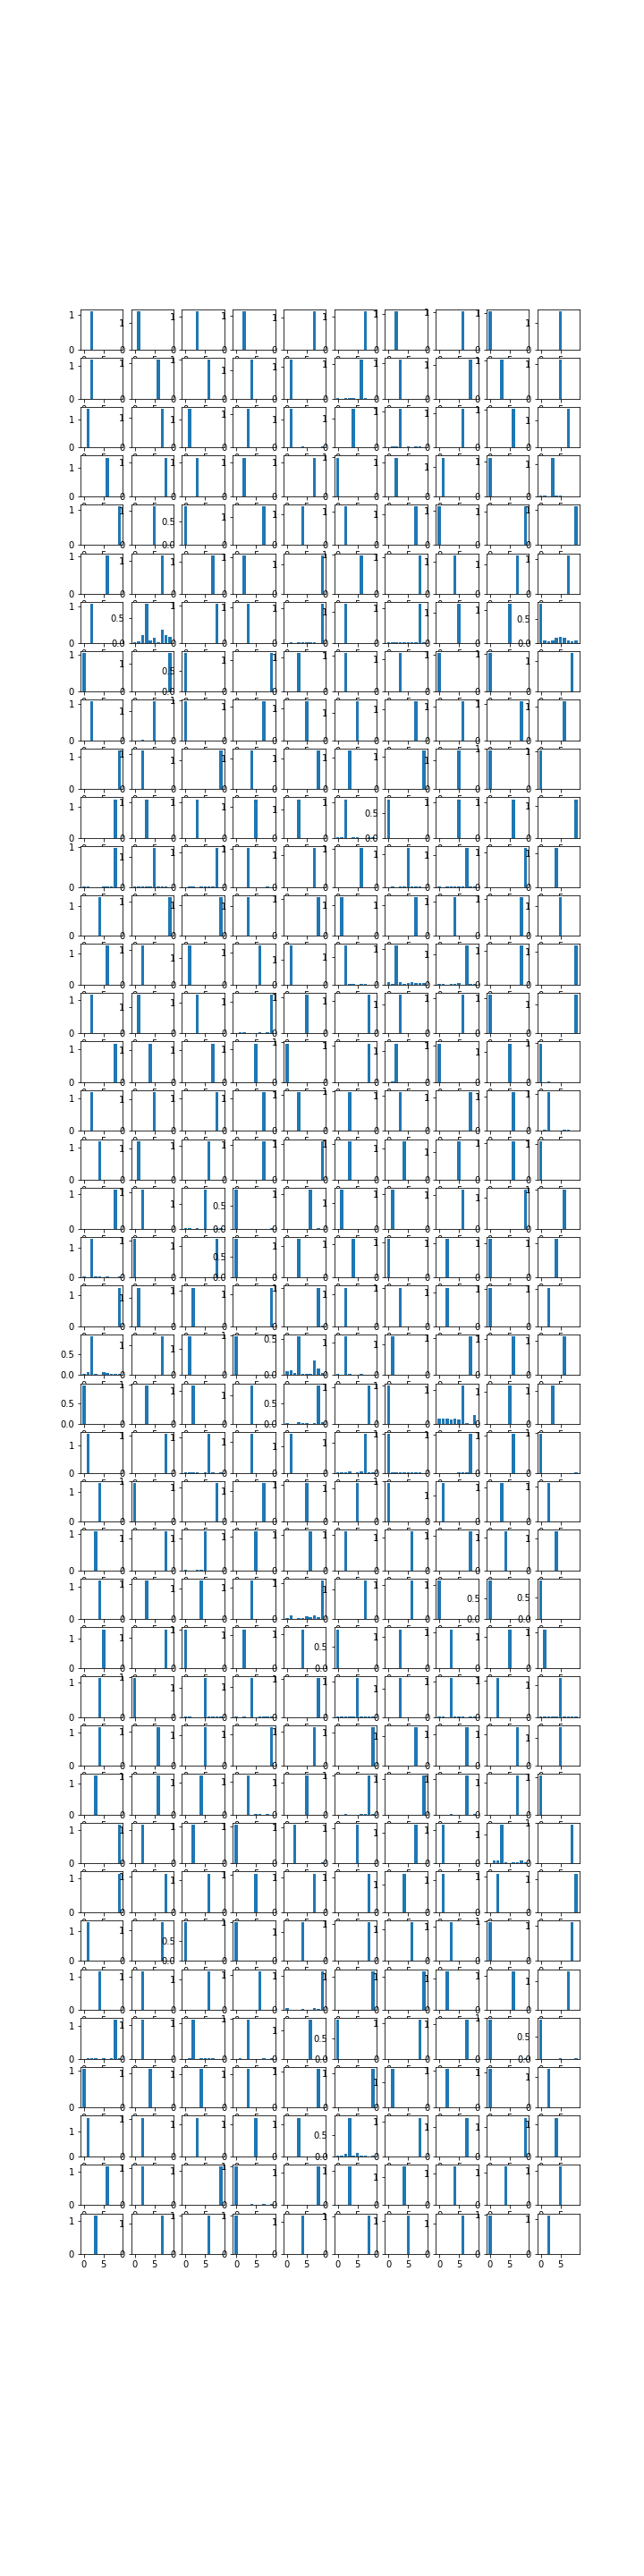

In [99]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Kx = 20
Ky = 20
Nep = 10
T_s = 60000
B = 100
R = 10
xi = 0.006

w = dream_comp_recon_weights(Kx, Ky, flat_x, train_y, Nep, T_s, B, R, xi, fig, True)
acc = recon_classification(w, flat_test, test_y)
plot_class_weights(w, 10, 10, 40)

Hell yeah.  That's what I'm fucking talking about.  So my 400 neuron network is doing about as good as Diehl's network with 6,400 neurons.  Yeah that's right.  

Y'all, I just realized how I could train this network with only a couple labels.  You basically just train the network as usual, and when you have labels, you feed them into the network.  When labels aren't present, the network basically just dreams of the labels, and does its best to provide the correct classification.  Now, if there are several collaborative elements of the network, those might provide incorrect classifications, so the predictions would allow the network to continue training, and moving away from classifications that are clearly incorrect.  

Now, the coolest shit would be if you had a pretty large learning constant for inputs that don't update as frequently.  Holy shit, that's one-shot learning.  If the classification neuron is getting a ton of natural external information, then you keep the learning constant low, so that the network is resilient to small perturbations.  If the classification neuron isn't getting a ton of natural external information, then you hike up the learning constant so that when it does get information about the truth source, it makes bigger changes to adjust the synapses to reflect the truth value.  

Holy fucking shit.  I think I might have just cracked one-shot learning.  

And this is all entirely autonomous!  That means super parallelization, baby!!

Ok, I absolutely gotts to try 1,600 neurons and see what kind of sauce we be cooking.  First though, I'm going to change this network so that it makes larger changes to the classification neuron synapses.

Ok, let's try out this new one.

<IPython.core.display.Javascript object>


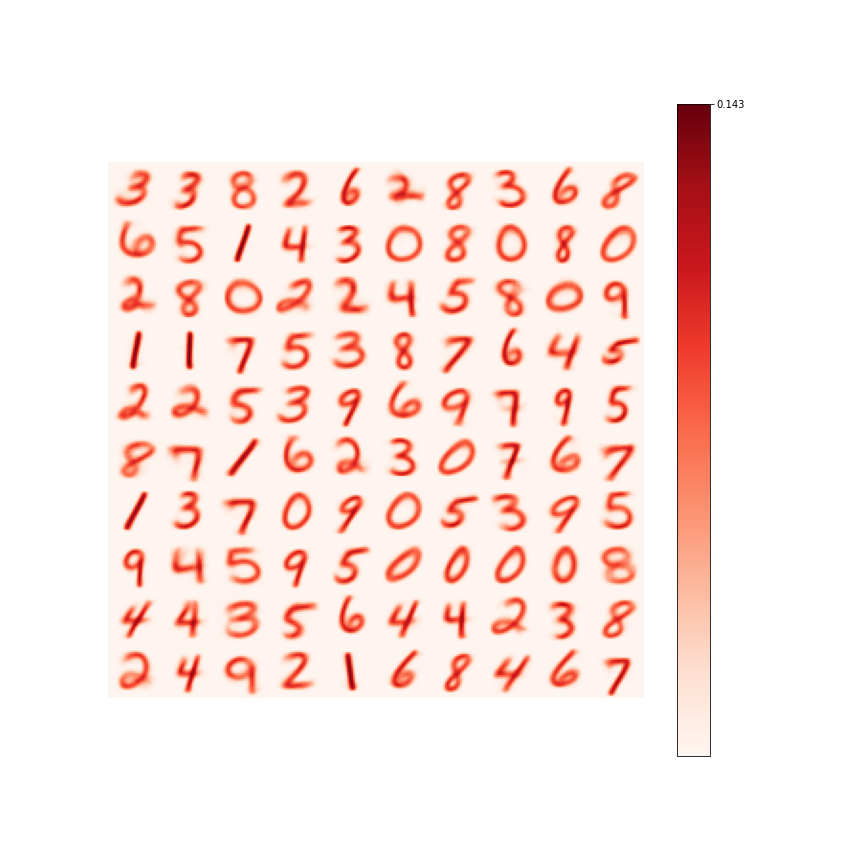

100%|██████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 772.31it/s]


Classes:  [3 3 8 2 6 2 8 3 6 8 6 5 1 4 3 0 8 0 8 0 2 8 0 2 2 4 5 8 0 9 1 1 7 5 3 8 7
 6 4 5 2 2 5 3 9 6 9 7 9 5 8 7 1 6 2 3 0 7 6 7 1 3 7 0 9 0 5 3 9 5 9 4 5 9
 5 0 0 0 0 8 4 4 3 5 6 4 4 2 3 8 2 4 9 2 1 6 8 4 6 7]
Accuracy:  92.15%


<IPython.core.display.Javascript object>


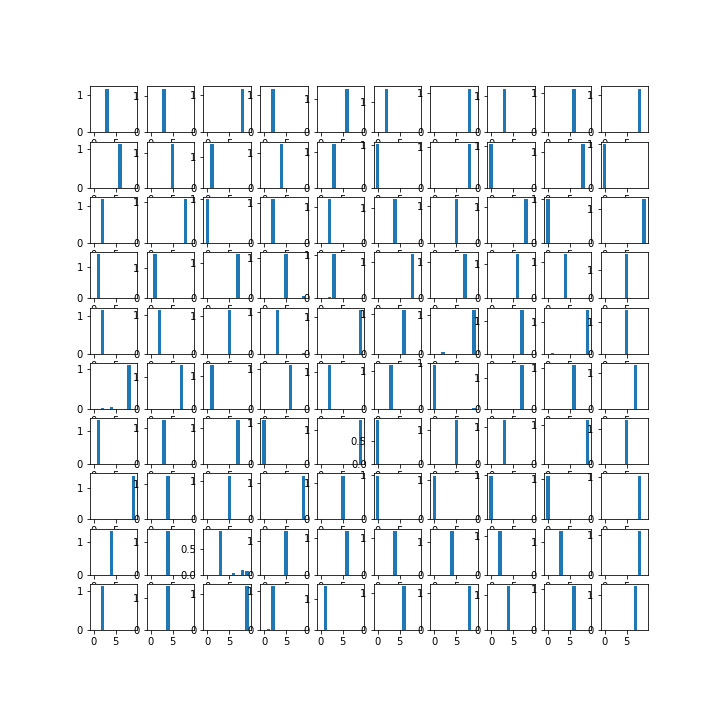

In [108]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Kx = 10
Ky = 10
Nep = 1
T_s = 60000
B = 100
R = 10
xi = 0.003
c_xi = 0.05

w = dream_comp_recon_weights_custom_xi(Kx, Ky, flat_x, train_y, Nep, T_s, B, R, xi, c_xi, fig, True)
acc = recon_classification(w, flat_test, test_y)
plot_class_weights(w, 10, Kx, Ky)

That's what I'm talking about, baby.  Now, let's try it with 400 neurons.

<IPython.core.display.Javascript object>


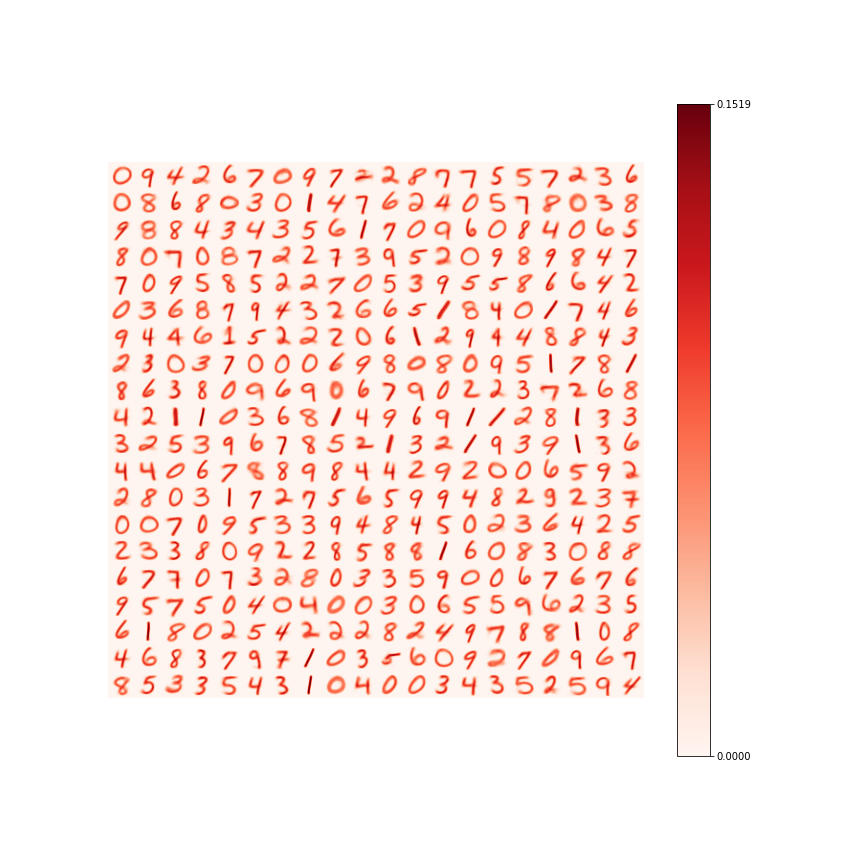

100%|██████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 120.01it/s]


Classes:  [0 9 4 2 6 7 0 9 7 2 2 8 7 7 5 5 7 2 3 6 0 8 6 8 0 3 0 1 4 7 6 2 4 0 5 7 8
 0 3 8 9 8 8 4 3 4 3 5 6 1 7 0 9 6 0 8 4 0 6 5 8 0 7 0 8 7 2 2 7 3 9 5 2 0
 9 8 9 8 4 7 7 0 9 5 8 5 2 2 7 0 5 3 9 5 5 8 6 6 4 2 0 3 6 8 7 9 4 3 2 6 6
 5 1 8 4 0 1 7 4 6 9 4 4 6 1 5 2 2 2 0 6 1 2 9 4 4 8 8 4 3 2 3 0 3 7 0 0 0
 6 9 8 0 8 0 9 5 1 7 8 1 8 6 3 8 0 9 6 9 0 6 7 9 0 2 2 3 7 2 6 8 4 2 1 1 0
 3 6 8 1 4 9 6 9 1 1 2 8 1 3 3 3 2 5 3 9 6 7 8 5 2 1 3 2 1 9 3 9 1 3 6 4 4
 0 6 7 8 8 9 8 4 4 2 9 2 0 0 6 5 9 2 2 8 0 3 1 7 2 7 5 6 5 9 9 4 8 2 9 2 3
 7 0 0 7 0 9 5 3 3 9 4 8 4 5 0 2 3 6 4 2 5 2 3 3 8 0 9 2 2 8 5 8 8 1 6 0 8
 3 0 8 8 6 7 7 0 7 3 2 8 0 3 3 5 9 0 0 6 7 6 7 6 9 5 7 5 0 4 0 4 0 0 3 0 6
 5 5 9 6 2 3 5 6 1 8 0 2 5 4 2 2 2 8 2 4 9 7 8 8 1 0 8 4 6 8 3 7 9 7 1 0 3
 5 6 0 9 2 7 0 9 6 7 8 5 3 3 5 4 3 1 0 4 0 0 3 4 3 5 2 5 9 4]
Accuracy:  95.04%


<IPython.core.display.Javascript object>


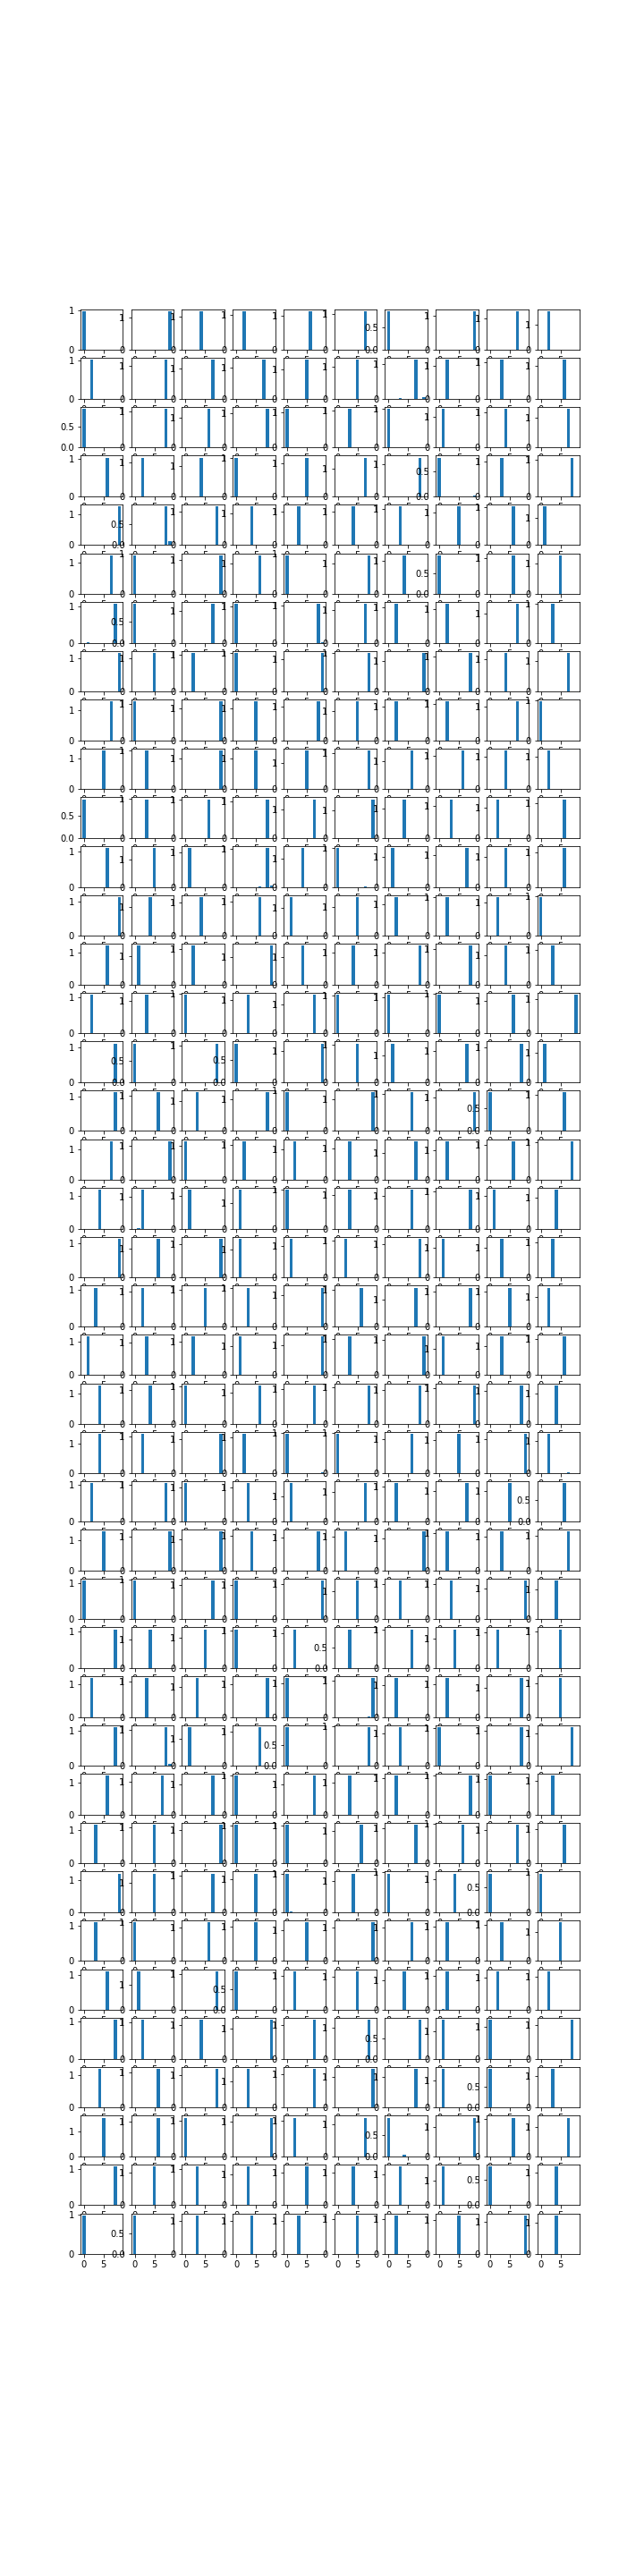

In [111]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Kx = 20
Ky = 20
Nep = 10
T_s = 60000
B = 100
R = 10
xi = 0.006
c_xi = 0.05

w = dream_comp_recon_weights_custom_xi(Kx, Ky, flat_x, train_y, Nep, T_s, B, R, xi, c_xi, fig, True)
acc = recon_classification(w, flat_test, test_y)
plot_class_weights(w, 10, 10, 40)

Hell yeah, that's what I want to see.

<IPython.core.display.Javascript object>


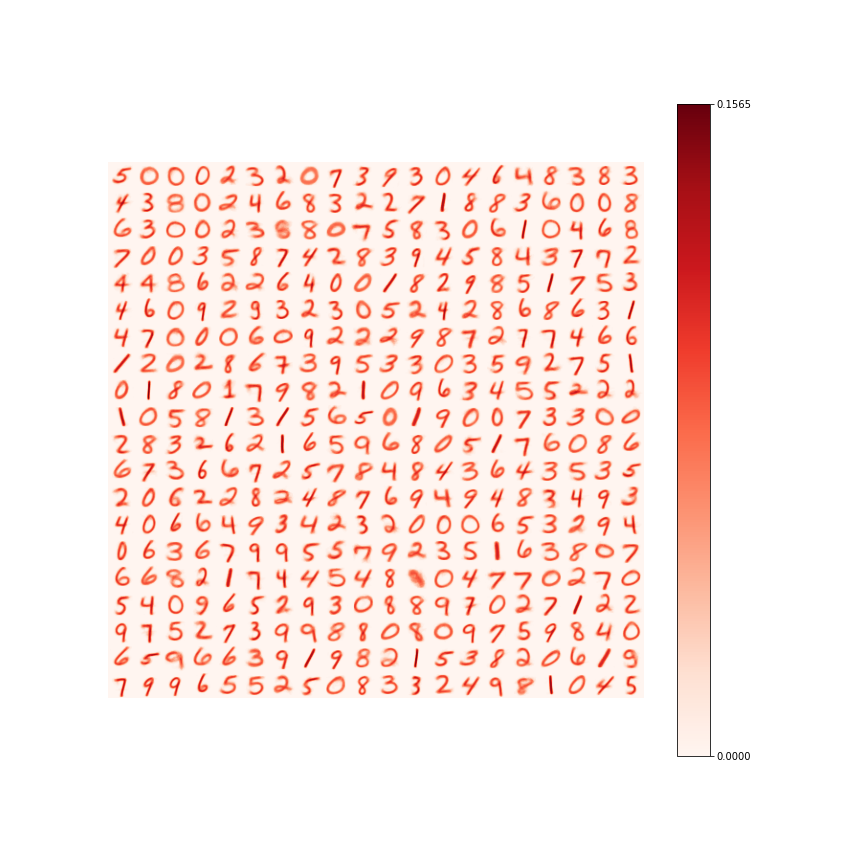

100%|██████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 118.12it/s]


Classes:  [5 0 0 0 2 3 2 0 7 3 9 3 0 4 6 4 8 3 8 3 4 3 8 0 2 4 6 8 3 2 2 7 1 8 8 3 6
 0 0 8 6 3 0 0 2 3 8 8 0 7 5 8 3 0 6 1 0 4 6 8 7 0 0 3 5 8 7 4 2 8 3 9 4 5
 8 4 3 7 7 2 4 4 8 6 2 2 6 4 0 0 1 8 2 9 8 5 1 7 5 3 4 6 0 9 2 9 3 2 3 0 5
 2 4 2 8 6 8 6 3 1 4 7 0 0 0 6 0 9 2 2 2 9 8 7 2 7 7 4 6 6 1 2 0 2 8 6 7 3
 9 5 3 3 0 3 5 9 2 7 5 1 0 1 8 0 1 7 9 8 2 1 0 9 6 3 4 5 5 2 2 2 1 0 5 8 1
 3 1 5 6 5 0 1 9 0 0 7 3 3 0 0 2 8 3 2 6 2 1 6 5 9 6 8 0 5 1 7 6 0 8 6 6 7
 3 6 6 7 2 5 7 8 4 8 4 3 6 4 3 5 3 5 2 0 6 2 2 8 2 4 8 7 6 9 4 9 4 8 3 4 9
 3 4 0 6 6 4 9 3 4 2 3 2 0 0 0 6 5 3 2 9 4 0 6 3 6 7 9 9 5 5 7 9 2 3 5 1 6
 3 8 0 7 6 6 8 2 1 7 4 4 5 4 8 9 0 4 7 7 0 2 7 0 5 4 0 9 6 5 2 9 3 0 8 8 9
 7 0 2 7 1 2 2 9 7 5 2 7 3 9 9 8 8 0 8 0 9 7 5 9 8 4 0 6 5 9 6 6 3 9 1 9 8
 2 1 5 3 8 2 0 6 1 9 7 9 9 6 5 5 2 5 0 8 3 3 2 4 9 8 1 0 4 5]
Accuracy:  94.88%


<IPython.core.display.Javascript object>


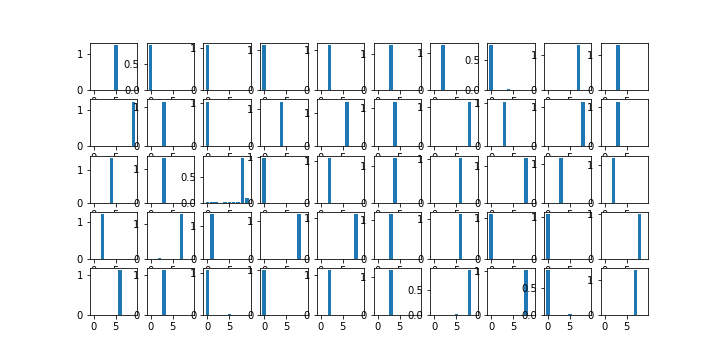

In [114]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Kx = 20
Ky = 20
Nep = 3
T_s = 60000
B = 100
R = 10
xi = 0.006
c_xi = 0.05

w = dream_comp_recon_weights_custom_xi(Kx, Ky, flat_x, train_y, Nep, T_s, B, R, xi, c_xi, fig, True)
acc = recon_classification(w, flat_test, test_y)
plot_class_weights(w, 10, 10, 5)

Ok, if I lower it down to three epochs, it doesn't do too poorly.  I'm going to hike up c_xi and xi and see if I can get this to go faster.

<IPython.core.display.Javascript object>


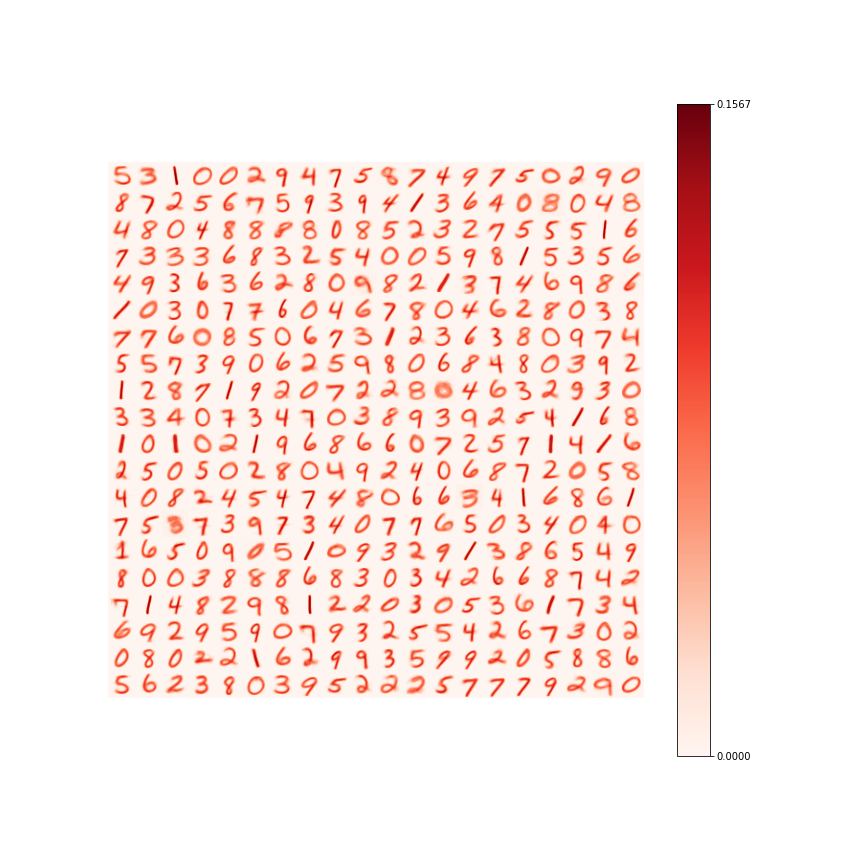

100%|██████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 117.43it/s]


Classes:  [5 3 1 0 0 2 9 4 7 5 8 7 4 9 7 5 0 2 9 0 8 7 2 5 6 7 5 9 3 9 4 1 3 6 4 0 8
 0 4 8 4 8 0 4 8 8 8 8 0 8 5 2 3 2 7 5 5 5 1 6 7 3 3 3 6 8 3 2 5 4 0 0 5 9
 8 1 5 3 5 6 4 9 3 6 3 6 2 8 0 9 8 2 1 3 7 4 6 9 8 6 1 0 3 0 7 7 6 0 4 6 7
 8 0 4 6 2 8 0 3 8 7 7 6 0 8 5 0 6 7 3 1 2 3 6 3 8 0 9 7 4 5 5 7 3 9 0 6 2
 5 9 8 0 6 8 4 8 0 3 9 2 1 2 8 7 1 9 2 0 7 2 2 8 0 4 6 3 2 9 3 0 3 3 4 0 7
 3 4 7 0 3 8 9 3 9 2 5 4 1 6 8 1 0 1 0 2 1 9 6 8 6 6 0 7 2 5 7 1 4 1 6 2 5
 0 5 0 2 8 0 4 9 2 4 0 6 8 7 2 0 5 8 4 0 8 2 4 5 4 7 4 8 0 6 6 3 4 1 6 8 6
 1 7 5 3 7 3 9 7 3 4 0 7 7 6 5 0 3 4 0 4 0 1 6 5 0 9 0 5 1 0 9 3 2 9 1 3 8
 6 5 4 9 8 0 0 3 8 8 8 6 8 3 0 3 4 2 6 6 8 7 4 2 7 1 4 8 2 9 8 1 2 2 0 3 0
 5 3 6 1 7 3 4 6 9 2 9 5 9 0 7 9 3 2 5 5 4 2 6 7 3 0 2 0 8 0 2 2 1 6 2 9 9
 3 5 9 9 2 0 5 8 8 6 5 6 2 3 8 0 3 9 5 2 2 2 5 7 7 7 9 2 9 0]
Accuracy:  94.47%


<IPython.core.display.Javascript object>


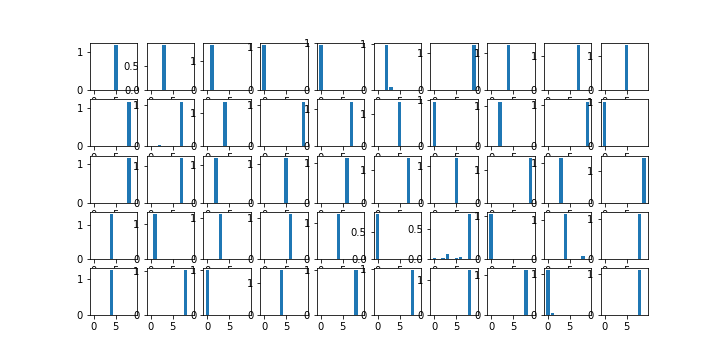

In [116]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Kx = 20
Ky = 20
Nep = 1
T_s = 60000
B = 100
R = 10
xi = 0.008
c_xi = 0.1

w = dream_comp_recon_weights_custom_xi(Kx, Ky, flat_x, train_y, Nep, T_s, B, R, xi, c_xi, fig, True)
acc = recon_classification(w, flat_test, test_y)
plot_class_weights(w, 10, 10, 5)

Darn right.  That's real good.  Ok, let's juice this on 1,600 neurons and see how that mother fucker flies.

<IPython.core.display.Javascript object>


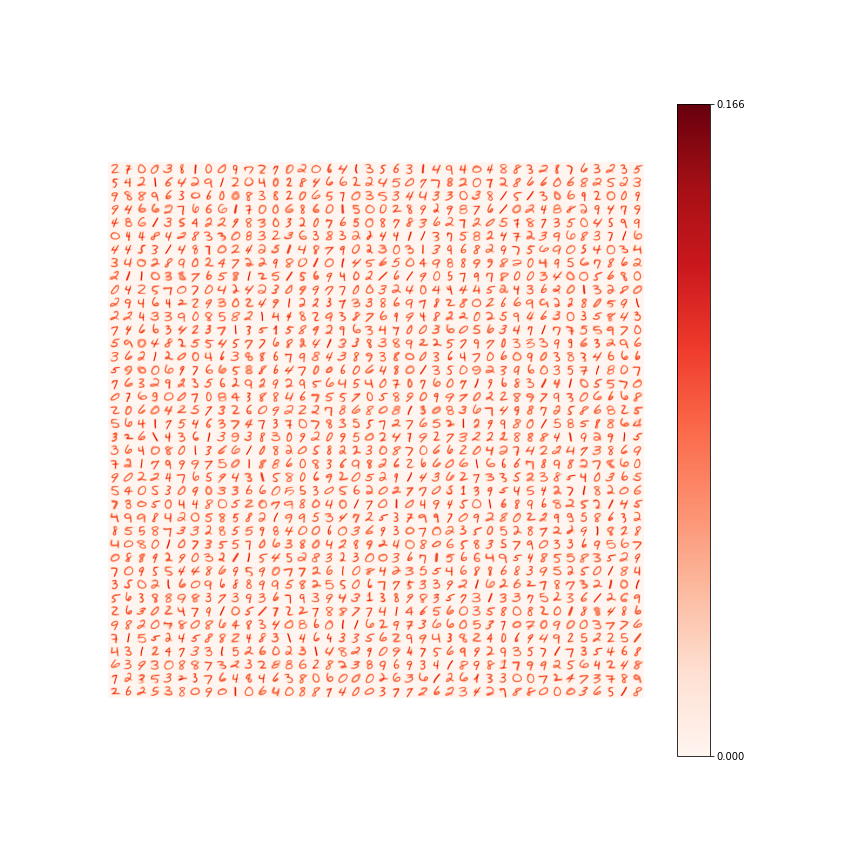

100%|███████████████████████████████████████████████████████████████| 120/120 [00:07<00:00, 16.24it/s]


Classes:  [2 7 0 ... 5 1 8]
Accuracy:  96.28%


<IPython.core.display.Javascript object>


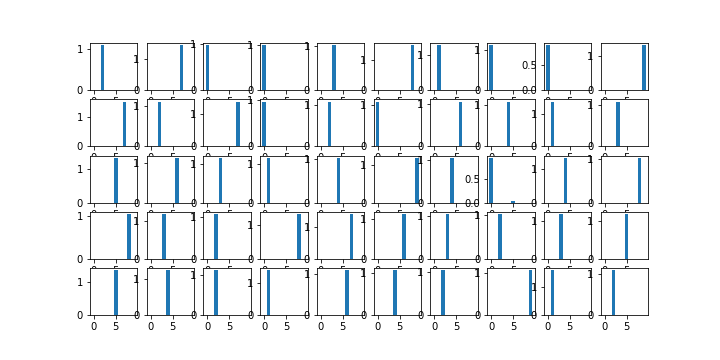

In [7]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Kx = 40
Ky = 40
Nep = 10
T_s = 60000
B = 500
R = 10
xi = 0.008
c_xi = 0.1

w = dream_comp_recon_weights_custom_xi(Kx, Ky, flat_x, train_y, Nep, T_s, B, R, xi, c_xi, fig, True)
acc = recon_classification(w, flat_test, test_y)
plot_class_weights(w, 10, 10, 5)

Damn straight!  Let's see if we can juice 97% from 6,400 neurons.

<IPython.core.display.Javascript object>


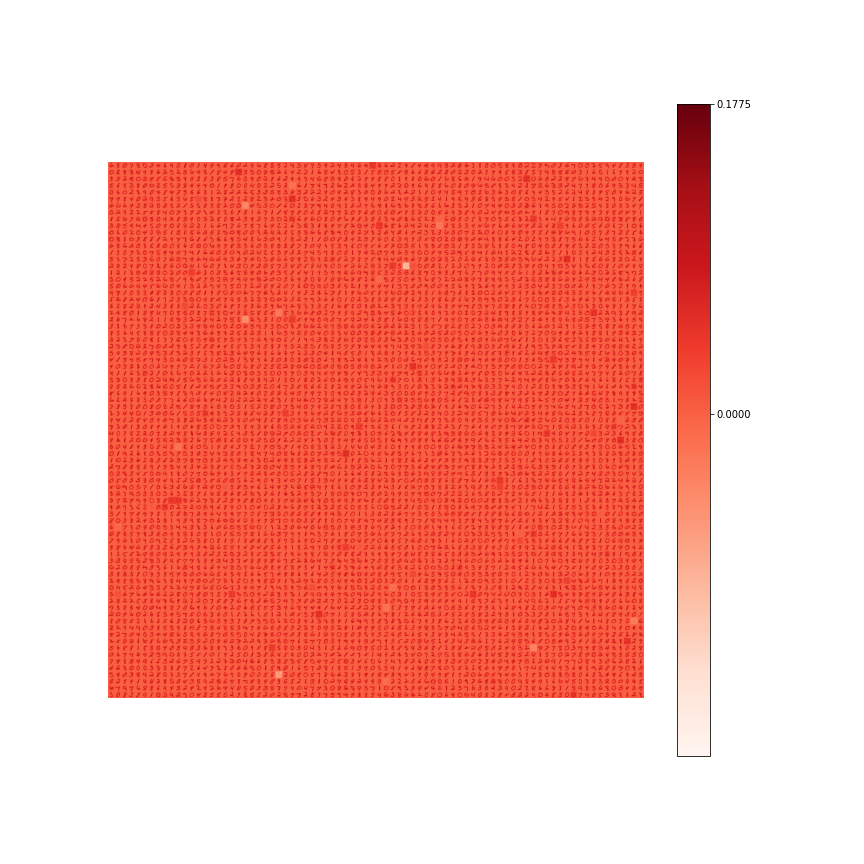

100%|███████████████████████████████████████████████████████████████| 120/120 [00:32<00:00,  3.70it/s]


Classes:  [6 8 0 ... 6 2 8]
Accuracy:  95.95%


<IPython.core.display.Javascript object>


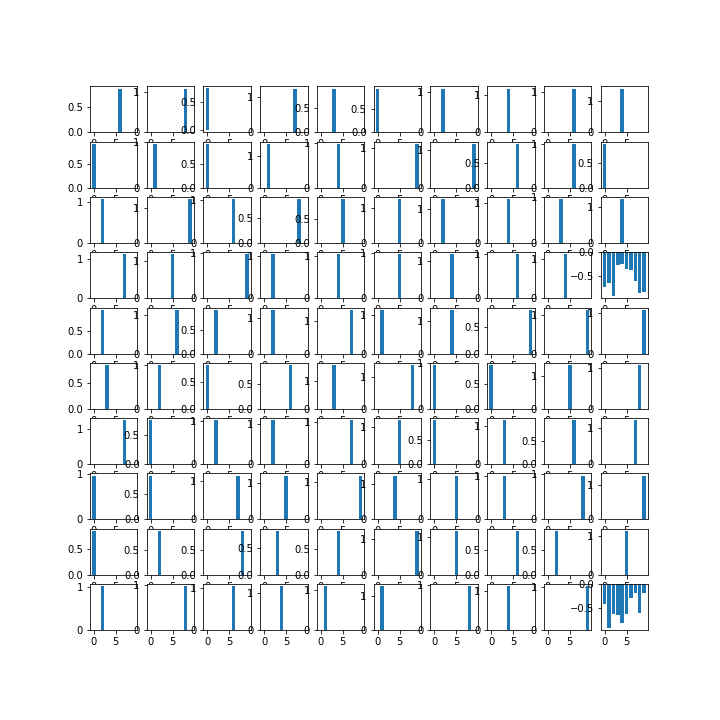

In [8]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Kx = 80
Ky = 80
Nep = 10
T_s = 60000
B = 500
R = 10
xi = 0.009
c_xi = 0.2

w = dream_comp_recon_weights_custom_xi(Kx, Ky, flat_x, train_y, Nep, T_s, B, R, xi, c_xi, fig, True)
acc = recon_classification(w, flat_test, test_y)
plot_class_weights(w, 10, 10, 10)

Wow.  That's simply no good.  I'm going to take the xis down a bit, and see what goes.  

Actually, I'm going to really go for this one, so we're going to do 20 epochs.

<IPython.core.display.Javascript object>


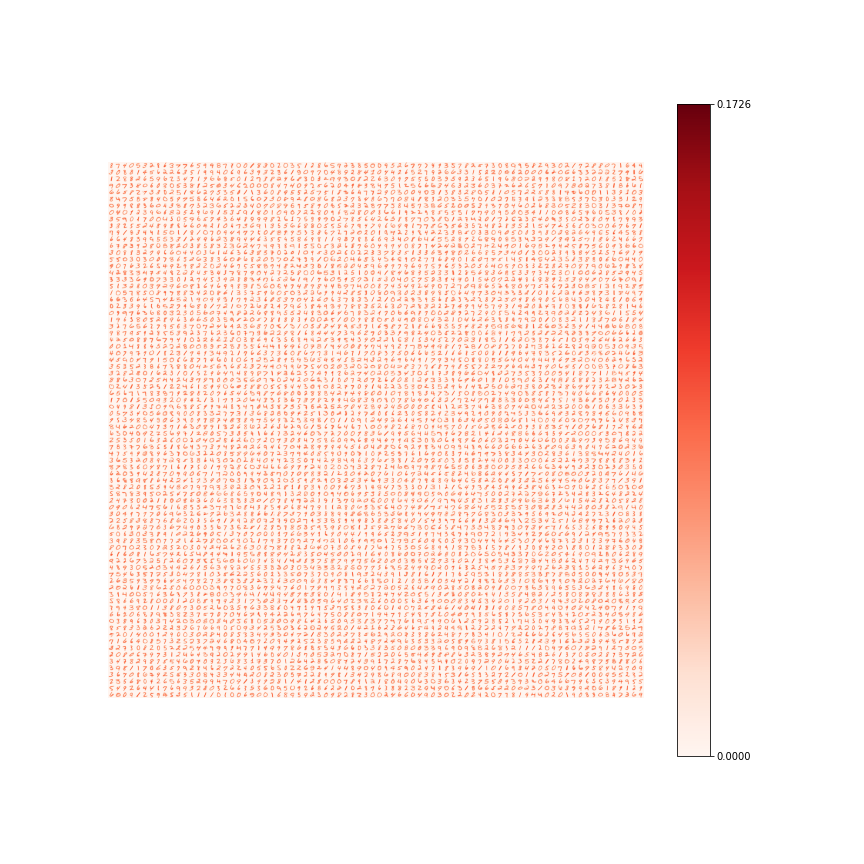

100%|███████████████████████████████████████████████████████████████| 120/120 [00:32<00:00,  3.69it/s]


Classes:  [8 7 4 ... 3 6 9]
Accuracy:  96.78999999999999%


<IPython.core.display.Javascript object>


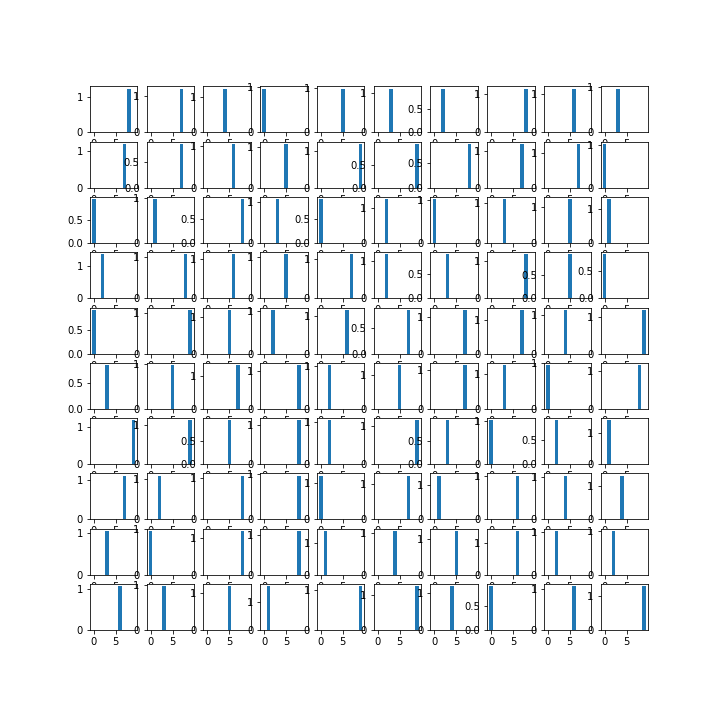

In [10]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Kx = 80
Ky = 80
Nep = 20
T_s = 60000
B = 500
R = 10
xi = 0.006
c_xi = 0.1

w = dream_comp_recon_weights_custom_xi(Kx, Ky, flat_x, train_y, Nep, T_s, B, R, xi, c_xi, fig, True)
acc = recon_classification(w, flat_test, test_y)
plot_class_weights(w, 10, 10, 10)

Well, I guess that's about as good as we can do 6,400 neurons.  Let's take a closer look at those prototypes.

<IPython.core.display.Javascript object>


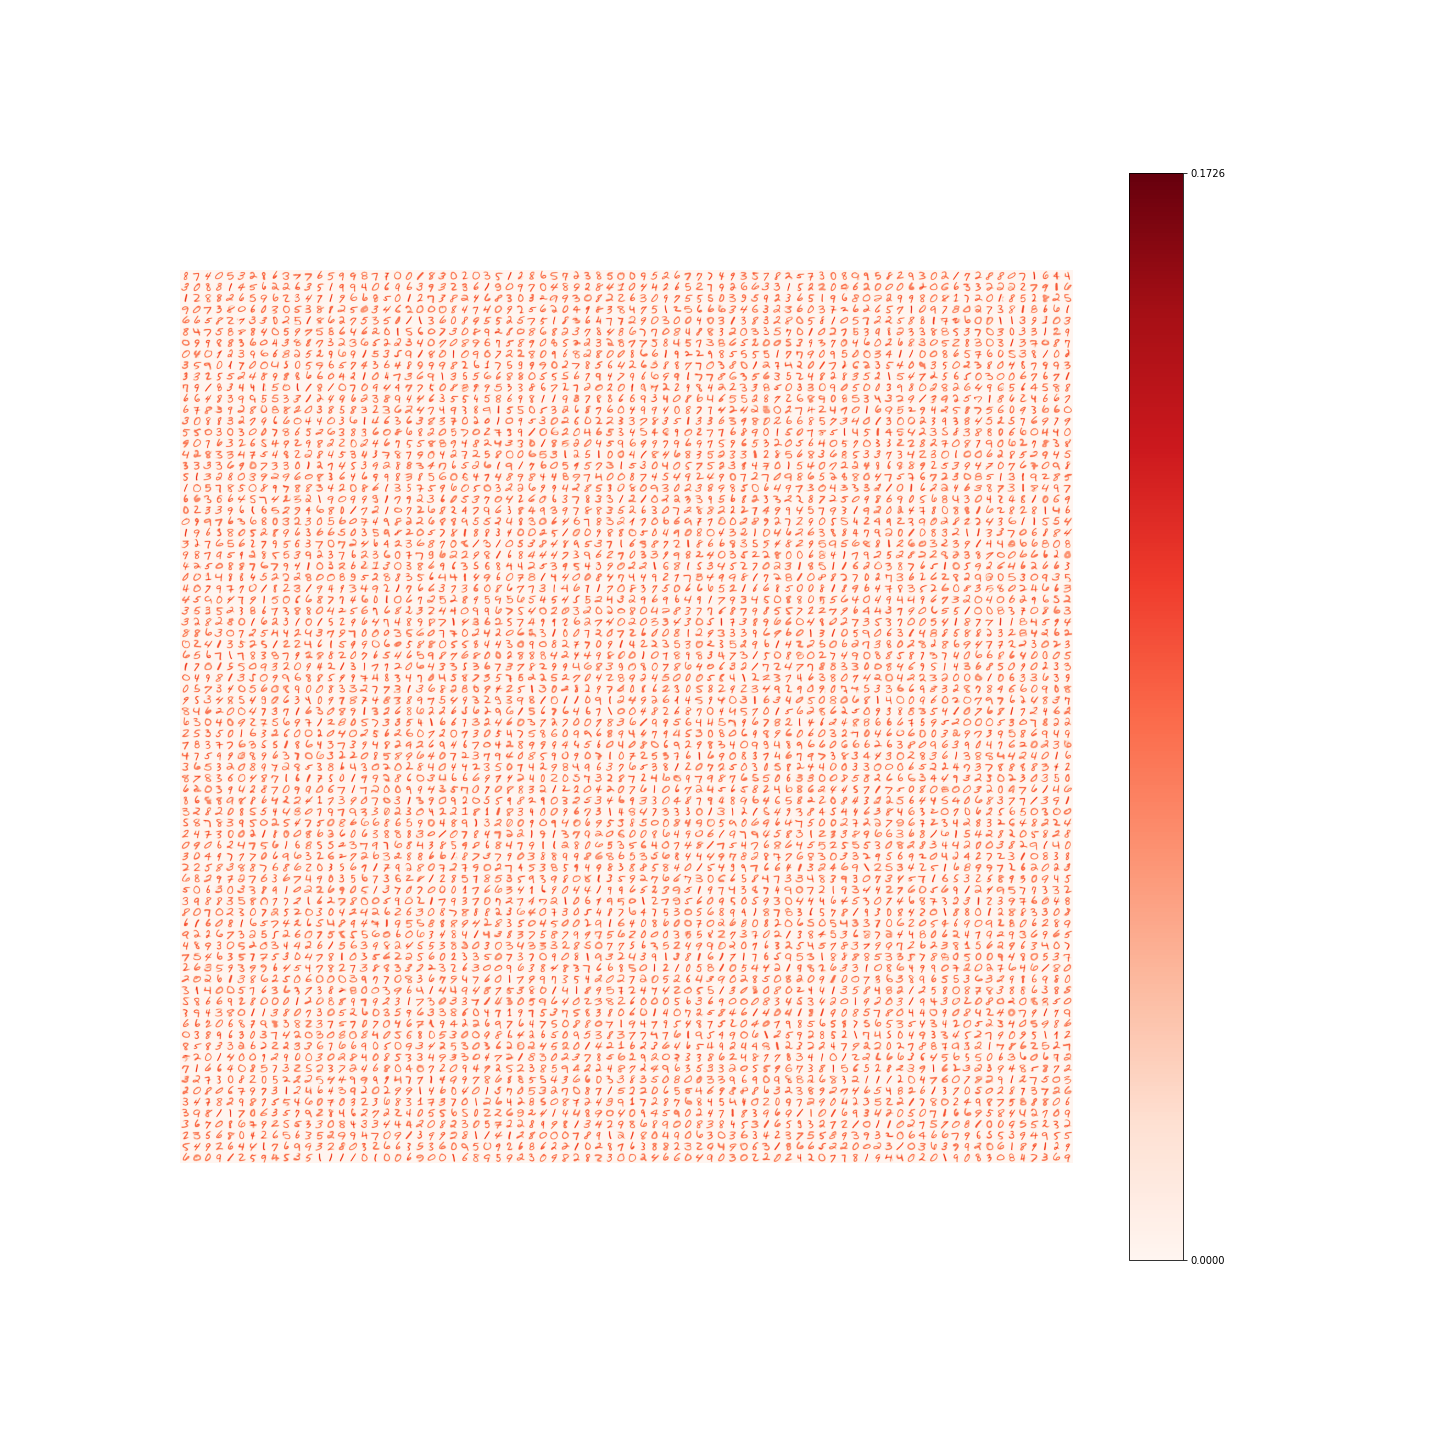

In [13]:
fig = plt.figure(figsize=(20, 20))
draw_weights(w[:, :-10], Kx, Ky, fig)

You know what?  I bet it's over-fitting!  Let's see the accuracy on the main training set.  

In [14]:
acc = recon_classification(w, flat_x, train_y)

Classes:  [8 7 4 ... 3 6 9]
Accuracy:  99.12666666666667%


Haha yup!!  I can't believe I never thought to check that before!  And you know what?  That totally makes sense!!  

It's not over-fitting, it's memorizing! Well, I mean it is over-fitting, but that's only because it's *trying* to memorize the data!  So it's literally trying to match the data it has learned to each new input.  But that's very, very brittle!  What if there's some symmetry in the dataset, like translational symmetry?  Or what if the data just doesn't fit very well with what has been memorized?  Then that data is misclassified!   

So it would be way better to learn about the constituent parts that make up the dataset, and be able to classify based on those things alone.  Yeah, wow.  It'd probably be way more effective to have a bunch of local competitions going on, and the winner from each of those competitions tries to reconstruct the input.

Wait.  Hold on.

I just realized how this flows.  The forward flow is the prototype, and the backward flow is the prediction.  

This whole system can be thought of as two huge matrices, and neurons either have even or odd parity.  Basically, the even neurons run and do their thing, and then the odd neurons run and do their thing.  And actually weights should be calculated from the side of the pre-synaptic neuron.  

Wow, this is super dope.  Actually, I think I'm going to wrap this experiment up and move on because I'm had an insight into how all this should work.  

And yeah, I think I might be able to get super good performance potentially with only a couple training examples.  

Wow, my brain is kinda exploding right now.  In like a good way.

## Conclusions

Recon Weights work like I wanted them to work, but I don't think that's the most important thing right now.  And actually, I think they might just happen naturally when the reconstruction is occurring from several locations.  

So yeah, I need to get to work on this forward-backward flow model.  I think it might just be nirvana.

## Next steps

Reach nirvana.  Come back to Recon Weights if it's clear at some point that they're a good idea.